In [ ]:
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from statsmodels.tsa.seasonal import seasonal_decompose

                 date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0 2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1 2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2 2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3 2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4 2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


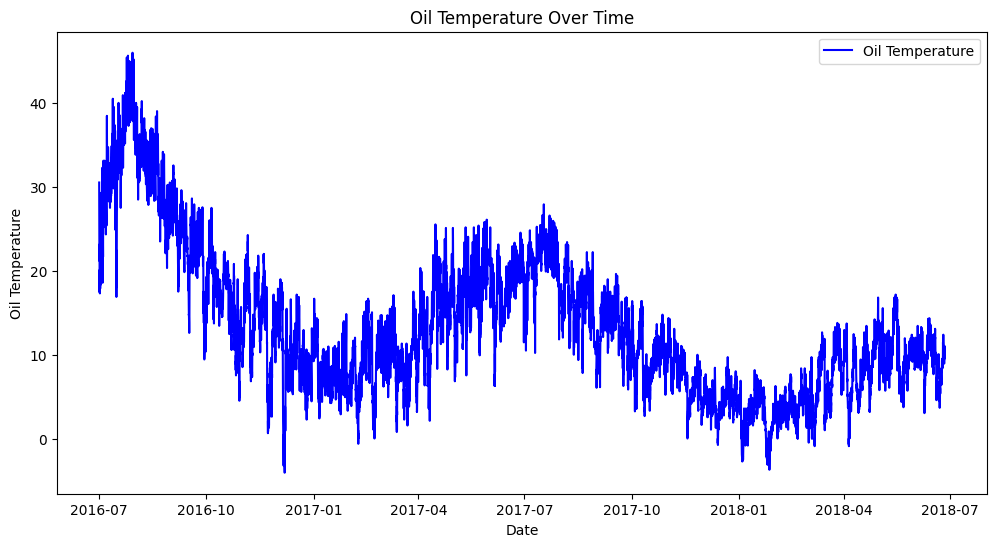

In [ ]:
odf = pd.read_csv('sample_data/ETTh1.csv')
odf['date'] = pd.to_datetime(odf['date'])
print(odf.head())

# Plot the oil temperature
plt.figure(figsize=(12, 6))
plt.plot(odf['date'], odf['OT'], label='Oil Temperature', color='blue')
plt.title('Oil Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()



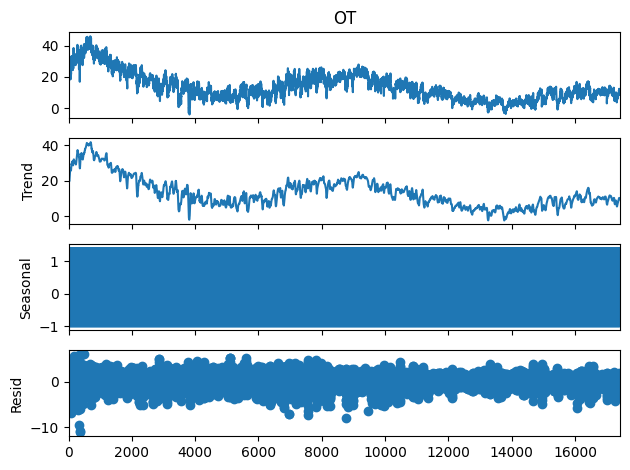

In [ ]:
result = seasonal_decompose(odf['OT'], model='additive', period=24)
result.plot()
plt.show()


The oil temperature data shows a clear downward trend but no significant seasonal pattern

In [ ]:
odf = odf.sort_values(by='date')
odf = odf.drop(columns=['date'])
print(odf.head())

    HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  5.358  1.942  1.492  0.462  3.868  1.279  21.948000


In [ ]:
samples_per_day = 24
train_days = 12 * 30
val_days = 6 * 30
sequence_length = 336
forecast_horizon = 96

train_size = train_days * samples_per_day
val_size = val_days * samples_per_day

train_mean = odf[:train_size].mean(axis=0)
train_std = odf[:train_size].std(axis=0)

odf = (odf - train_mean) / train_std

train_data = odf[:train_size]
val_data = odf[train_size:train_size + val_size]
test_data = odf[train_size + val_size:]


In [ ]:
print(f"Train size: {len(train_data)} samples")
print(f"Validation size: {len(val_data)} samples")
print(f"Test size: {len(test_data)} samples")

Train size: 8640 samples
Validation size: 4320 samples
Test size: 4460 samples


In [ ]:
# I have used AI for this block and also taken the lab notes as refernce
# I have faced out of bounds error due to not splitting the data in right way
# prompt i used is<How to avoid out of bound errors while creating timeseries data?>
delay = sequence_length + forecast_horizon - 1
train_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=train_data[:-delay],
    targets=train_data['OT'][delay:],
    sequence_length=sequence_length,
    batch_size=256,
    start_index=0,
    end_index=min(train_size, len(train_data) - delay -1)
)

val_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=val_data[:-delay],
    targets=val_data['OT'][delay:],
    sequence_length=sequence_length,
    batch_size=256,
    start_index=0,
    end_index=min(val_size, len(val_data) - delay - 1)
)

test_dataset = keras.preprocessing.timeseries_dataset_from_array(
    data=test_data[:-delay],
    targets=test_data['OT'][delay:],
    sequence_length=sequence_length,
    batch_size=256,
    start_index=0,
    end_index=min(len(test_data) - delay -1, len(test_data) )
)

In [ ]:
for batch in train_dataset.take(1):
    inputs, targets = batch
    print(f"Input shape: {inputs.shape}")
    print(f"Target shape: {targets.shape}")

Input shape: (256, 336, 7)
Target shape: (256,)


In [ ]:
def unnormalize(preds, targets, mean, std):
    preds = preds * std + mean
    targets = targets * std + mean
    return preds, targets

def evaluate_model(dataset, model=None):
    total_abs_err = 0.0
    num_sequences = 0
    temp_index = 6

    for samples, targets in dataset:
        if model is None:
            preds = samples[:, -1, temp_index]
        else:
            preds = model.predict(samples, verbose=0).flatten()

        preds, targets = unnormalize(preds, targets, train_mean.iloc[temp_index], train_std.iloc[temp_index])
        total_abs_err += np.sum(np.abs(preds - targets))
        num_sequences += samples.shape[0]

    return total_abs_err / num_sequences

baseline_mae = evaluate_model(val_dataset)
print(f"Validation MAE Baseline: {baseline_mae:.2f}")


Validation MAE Baseline: 2.69


In [ ]:
num_features = odf.shape[-1]

def build_lstm(sequence_length, num_features):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1)(x)
    lstm_model = keras.Model(inputs, outputs)
    return lstm_model

lstm_model = build_lstm(sequence_length=sequence_length, num_features=num_features)

checkpoint = keras.callbacks.ModelCheckpoint("best_lstm_model.keras", save_best_only=True)
rop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)
lstm_model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),loss="mse", metrics=["mae"])
history = lstm_model.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[checkpoint, early_stopping, rop])

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 1.1925 - mae: 0.8880 - val_loss: 0.5218 - val_mae: 0.5913 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.8989 - mae: 0.7596 - val_loss: 0.5078 - val_mae: 0.5851 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.7264 - mae: 0.6680 - val_loss: 0.4875 - val_mae: 0.5787 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.6288 - mae: 0.6142 - val_loss: 0.4614 - val_mae: 0.5686 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.5394 - mae: 0.5701 - val_loss: 0.4313 - val_mae: 0.5543 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.4681 - mae: 0.5300 - val_loss: 0.3991 - val_mae: 0.5361 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.4237 - mae: 0.5047 - val_loss: 0.3706 - val_mae: 0.5181 - learning_r

In [ ]:
print(lstm_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 336, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 336, 64)             │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,645 (361.90 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,764 (241.27 KB)

None


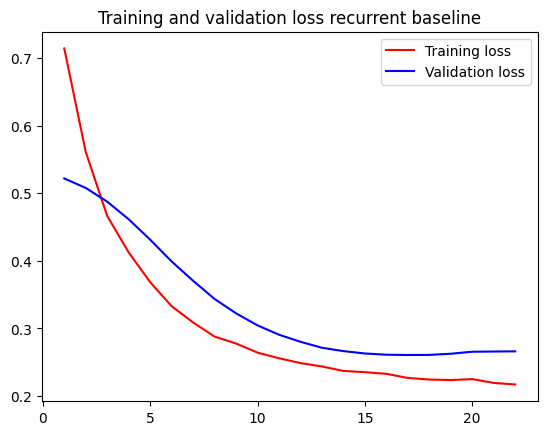

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss recurrent baseline')
plt.legend()
plt.show()

Training and validation loss decrease steadily with minimal gap, showing good learning and no overfitting.

In [ ]:
lstm_model = keras.models.load_model("best_lstm_model.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=lstm_model):.2f}")


Validation MAE lstm: 3.95


The LSTM model did not beat the baseline model

In [ ]:
def build_stacked_lstm(sequence_length, num_features, learning_rate):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.GRU(64, return_sequences=True)(inputs)
    x = layers.GRU(32)(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
best_learning_rate = 0.0001
num_features = odf.shape[-1]
lstm_model1 = build_stacked_lstm(sequence_length=sequence_length, num_features=num_features, learning_rate=best_learning_rate)

checkpoint = keras.callbacks.ModelCheckpoint("best_lstm_model1.keras", save_best_only=True)
rop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-4, restore_best_weights=True)

lstm_model1.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=best_learning_rate, weight_decay=1e-5),loss="mse", metrics=["mae"])

history = lstm_model1.fit(train_dataset,epochs=50,validation_data=val_dataset,callbacks=[checkpoint, early_stopping, rop])


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 1.9685 - mae: 1.1305 - val_loss: 0.7380 - val_mae: 0.7046 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 1.5618 - mae: 0.9940 - val_loss: 0.6948 - val_mae: 0.6767 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 1.3060 - mae: 0.8914 - val_loss: 0.6649 - val_mae: 0.6610 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.0637 - mae: 0.7918 - val_loss: 0.6383 - val_mae: 0.6508 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.9169 - mae: 0.7307 - val_loss: 0.6078 - val_mae: 0.6397 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.8104 - mae: 0.6847 - val_loss: 0.5711 - val_mae: 0.6243 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.7330 - mae: 0.6514 - val_loss: 0.5294 - val_mae: 0.6047 - learning_r

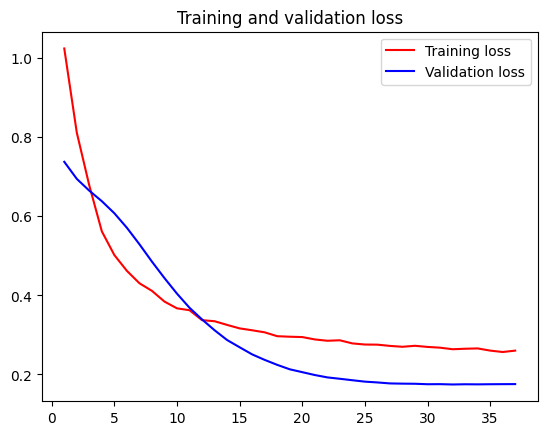

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This plot shows steady improvement in both training and validation loss, with a minimal gap. Compared to the previous graph, validation loss here decreases more consistently, indicating better generalization.

In [ ]:
stacked_lstm_model = keras.models.load_model("best_lstm_model1.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=stacked_lstm_model):.2f}")

Validation MAE lstm: 3.11


Tuned the sequence length in the range (48, 96, 120, 336). Out of all, sequence length 336 gave the best MAE of 3.11. Where as seq_len 48 has given MAE of 3.17,96 has has given MAE of 3.35,seq_len 120 has given MAE of 3.70

In [ ]:
def build_1dconv(sequence_length, num_features):
    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.Conv1D(8, 24, activation="relu",padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(8, 12, activation="relu",padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(8, 8, activation="relu",padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    return model

conv1D_model = build_1dconv(sequence_length, num_features)
conv1D_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 336, 7)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 336, 8)              │           1,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 168, 8)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 168, 8)              │             776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 84, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 84, 8)               │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,657 (10.38 KB)

 Trainable params: 2,657 (10.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint= keras.callbacks.ModelCheckpoint("temp_conv1d.keras",save_best_only=True)
conv1D_model.compile(optimizer="adamW", loss="mse", metrics=["mae"])
history = conv1D_model.fit(train_dataset,
epochs=50,
validation_data=val_dataset,
callbacks=[checkpoint, rop])

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 1.9670 - mae: 1.1773 - val_loss: 0.4917 - val_mae: 0.5529 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 1.6448 - mae: 1.0224 - val_loss: 0.5285 - val_mae: 0.5772 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.9627 - mae: 0.7478 - val_loss: 0.6096 - val_mae: 0.6713 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.3859 - mae: 0.5020 - val_loss: 0.3548 - val_mae: 0.4870 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.9698 - mae: 0.7521 - val_loss: 0.4563 - val_mae: 0.5835 - learning_rate: 0.0010
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.3235 - mae: 0.4494 - val_loss: 0.2626 - val_mae: 0.4247 - learning_rate: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.5247 - mae: 0.5347 - val_loss: 0.4647 - val_mae: 0.5789 - learning_rate: 0.0010
Epoch 8/50
3

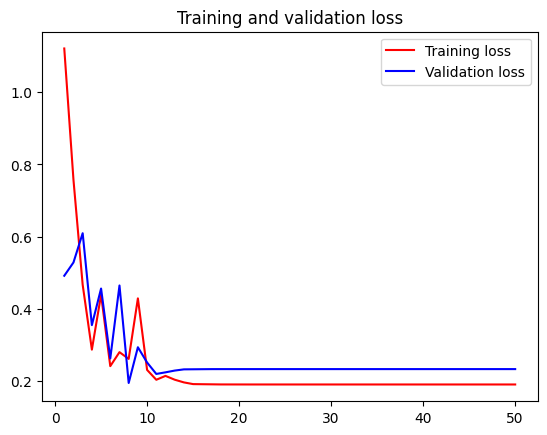

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The model learns well initially, with both training and validation losses stabilizing after 10 epochs. There’s no overfitting, and the performance is consistent.

In [ ]:
conv1D_model = keras.models.load_model("temp_conv1d.keras")

print(f"Validation MAE lstm: {evaluate_model(val_dataset, model=conv1D_model):.2f}")

Validation MAE lstm: 3.34


Tuned the Kernelsize between [24,12,8] [12,8,6],[8,6,4]. Kernel size of [24,12,8] has given the best MAE and out of all the model stacked LSTM model performed better

In [ ]:
best_model=keras.models.load_model("best_lstm_model1.keras")
test_mae_best_model = evaluate_model(test_dataset, model=best_model)
test_mae_commonsense_model = evaluate_model(test_dataset)

print(f"Test MAE for best model: {test_mae_best_model:.2f}")
print(f"Test MAE for commonsense model: {test_mae_commonsense_model:.2f}")

Test MAE for best model: 3.75
Test MAE for commonsense model: 2.90


The common sense model beats the best LSTM model

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


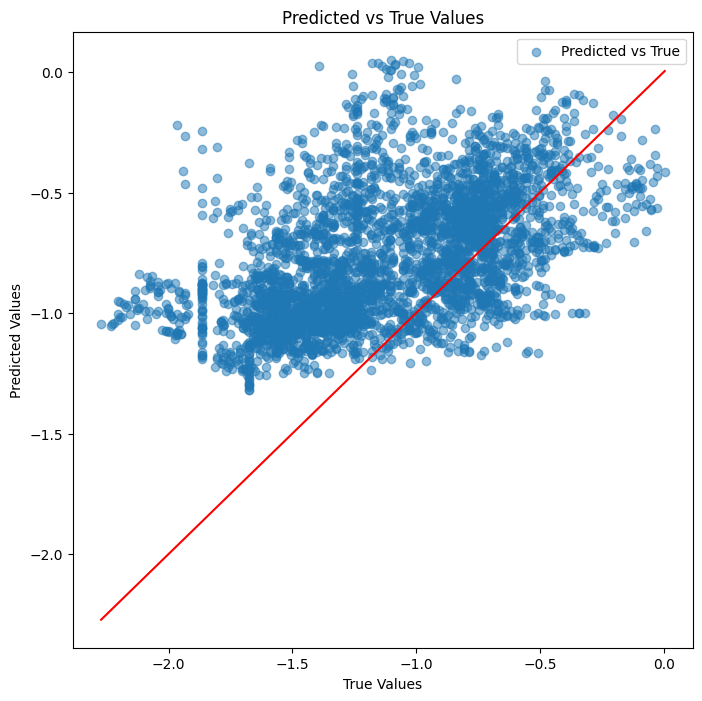

In [ ]:
true_values = [y for x, y in test_dataset]
true_values = np.concatenate(true_values, axis=0)

predicted_values = best_model.predict(test_dataset)
predicted_values = predicted_values.flatten()
plt.figure(figsize=(8, 8))
plt.scatter(true_values, predicted_values, alpha=0.5, label="Predicted vs True")
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], color='red')
plt.title("Predicted vs True Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

The plot shows predicted vs true values. Predictions align but with noticeable errors, suggesting room for improvement.